In [10]:
import xarray as xr
import pandas as pd
import numpy as np
import netCDF4
import scipy
import mjoindices.olr_handling as olr
import mjoindices.omi.wheeler_kiladis_mjo_filter

In [11]:
f = xr.open_dataset(r'C:\Users\lv299\OneDrive\Melbourne-Uni\Week 4\Monday\correction.nc')
ds = f.__xarray_dataarray_variable__
nds = ds.loc[:,20:-20.1,:]

In [12]:
varnds = nds.rolling(time = 91, center = True).var().dropna("time")

In [13]:
a = varnds.values
b = np.sqrt(a)
lat = varnds['lat']
lon = varnds['lon']
time = varnds['time']

sqrtvar = xr.DataArray(b,
coords = {'time' : time, 'lat' : lat, 'lon' : lon},
dims = ["time", "lat", "lon"])

In [14]:
c = sqrtvar.resample(time ="M").mean(dim="time")
dsmonth = c.resample(time='QS-NOV').mean(dim="time")
NDJ=dsmonth[0::4,:,:]
NDJ['time']=NDJ['time.year']
NDJ=NDJ.rename({'time': 'Year'})
NDJ.name = 'olr'
oni = pd.read_csv('Year_NDJ.txt',delim_whitespace=True,index_col=0)

new_ds = xr.merge([NDJ,oni.to_xarray()],join='inner')
print(new_ds)
Elnino = new_ds['olr'].loc[new_ds['NDJ']>0.5].mean(axis=0)
Lanina = new_ds['olr'].loc[new_ds['NDJ']<-0.5].mean(axis=0)
lat = new_ds['lat']
lon = new_ds['lon']

<xarray.Dataset>
Dimensions:  (Year: 41, lat: 17, lon: 144)
Coordinates:
  * Year     (Year) int64 1981 1982 1983 1984 1985 ... 2017 2018 2019 2020 2021
  * lat      (lat) float32 20.0 17.5 15.0 12.5 10.0 ... -12.5 -15.0 -17.5 -20.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    olr      (Year, lat, lon) float64 8.508 8.281 6.855 ... 2.502 2.149 2.735
    NDJ      (Year) float64 -0.1 2.2 -0.9 -1.1 -0.4 ... -1.0 0.8 0.5 -1.2 -1.0


In [15]:
sgl= (1983, 1988, 1995, 1998, 2005, 2007, 2010, 2016, 2020)
sgl = np.array(sgl,dtype = 'int32')
sgl =sgl -1981
dbl=(1984, 1999, 2008, 2011, 2017, 2021)
dbl = np.array(dbl,dtype = 'int32')
dbl = dbl -1981

In [17]:
Lasgl = new_ds.olr[sgl,:,:].mean(axis=0)
Ladbl = new_ds.olr[dbl,:,:].mean(axis=0)
Delta = Ladbl - Lasgl
Delta.min()

<xarray.DataArray 'olr' ()>
array(-7.53577335)

C:\Users\lv299\anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\lv299\anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\lv299\anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


C:\Users\lv299\anaconda3\lib\site-packages\cartopy\crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\lv299\anaconda3\lib\site-packages\cartopy\crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\lv299\anaconda3\lib\site-packages\cartopy\crs.py:402: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings.extend(multi_line_string)
C:\Users\lv299\anaconda3\lib\site-packages\cartopy\crs.py:402: ShapelyDeprecatio

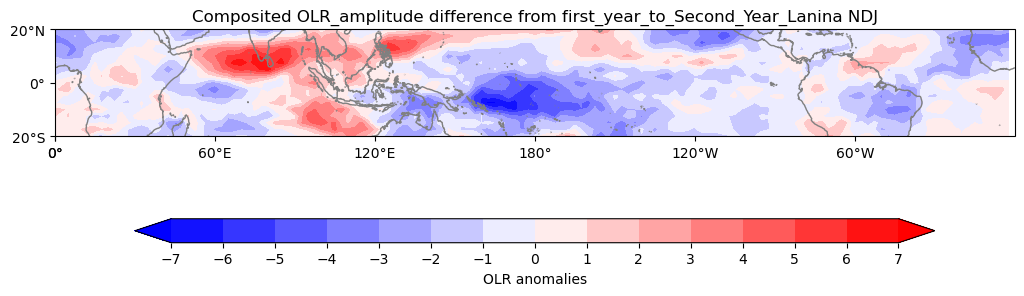

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 


leftlon, rightlon, lowerlat, upperlat = (0,420,-20,20)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

   
fig = plt.figure(figsize=(16,8))


ax = fig.add_axes([0.1, 0.2, 0.6, 0.6],projection = ccrs.PlateCarree(central_longitude=180),zorder=1)
ax.set_extent(img_extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,color='grey') 
ax.set_xticks(range(0,360+60,60), crs=ccrs.PlateCarree())
ax.set_yticks(range(-20,21,20), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.title.set_text('Composited OLR_amplitude difference from first_year_to_Second_Year_Lanina NDJ')

c = ax.contourf(lon,lat,Delta,
                levels=np.arange(-7,7.1,1),
                extend='both' ,
                cmap = plt.get_cmap('bwr'),
                transform=ccrs.PlateCarree(),zorder = 0)

fig.colorbar(c, cax=fig.add_axes([0.15, 0.3, 0.5, 0.03 ]),
             orientation='horizontal',  
             label= 'OLR anomalies', 
             ticks=np.arange(-7,7.1,1),
             shrink=0.7)